# DatafestAfrica ML Hackathon

First things first, let us import the neccesary packages

In [1]:
import os
import time
import numpy as np
import panda as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm

import optuna 
from optuna.samplers import TPESampler
from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier



from sklearn.model_selection import GridSearchCV


from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score

from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.linear_model import Ridge ,LinearRegression, LogisticRegression


from sklearn.model_selection import KFold,StratifiedKFold ,GroupKFold, cross_val_score, train_test_split, TimeSeriesSplit

from sklearn.metrics import *
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')



# magic word for producing visualizations in notebook
%matplotlib inline

# For displaying max number of lines
pd.set_option("display.max_rows", 500)

# For reproducability
SEED = 2


Now, we will now read in the train and test datasets

In [3]:
df_test = pd.read_csv("../input/datafestafrica-ml-hackathon/Data/test.csv")
df_test.head()

,Entry_id,age,pay_schedule,home_owner,income,months_employed,years_employed,current_address_year,personal_account_m,personal_account_y,has_debt,amount_requested,risk_score,risk_score_2,risk_score_3,risk_score_4,risk_score_5,ext_quality_score,ext_quality_score_2,inquiries_last_month
0,3560428,61,weekly,0,3180,0,6,3,2,7,1,600,30150,0.738510,0.881027,0.713423,0.826402,0.730720,0.630720,9
1,6934997,23,weekly,0,1540,6,0,0,7,1,1,450,34550,0.642993,0.766554,0.595018,0.762284,0.531712,0.531712,7
2,5682812,40,bi-weekly,0,5230,0,6,1,2,7,1,700,42150,0.665224,0.960832,0.767828,0.778831,0.792552,0.592552,8
3,6493191,32,semi-monthly,0,5260,3,0,3,1,4,1,1150,64050,0.652429,0.802433,0.593816,0.560389,0.569459,0.369459,3
4,8990111,61,bi-weekly,1,3270,0,4,0,4,3,1,400,61700,0.659736,0.937287,0.852323,0.785698,0.632466,0.732466,7


In [4]:
df_train = pd.read_csv("../input/datafestafrica-ml-hackathon/Data/train.csv")
df_train.head()

,Entry_id,age,pay_schedule,home_owner,income,months_employed,years_employed,current_address_year,personal_account_m,personal_account_y,...,amount_requested,risk_score,risk_score_2,risk_score_3,risk_score_4,risk_score_5,ext_quality_score,ext_quality_score_2,inquiries_last_month,e_signed
0,7629673,40,bi-weekly,1,3135,0,3,3,6,2,...,550,36200,0.737398,0.903517,0.487712,0.515977,0.580918,0.380918,10,1
1,5335819,33,semi-monthly,0,3590,0,5,2,2,8,...,1100,53850,0.617361,0.857560,0.613487,0.665523,0.744634,0.744634,12,0
2,8492423,21,weekly,0,2303,0,5,8,2,7,...,600,74850,0.677109,0.758765,0.495609,0.664762,0.592556,0.492556,6,1
3,7948313,26,bi-weekly,0,2795,0,4,4,1,6,...,800,50800,0.738055,0.873204,0.666437,0.700392,0.584130,0.684130,14,1
4,4297036,43,bi-weekly,0,5000,0,2,1,1,2,...,1100,69100,0.798303,0.841747,0.401971,0.568787,0.525905,0.725905,5,1


### Exploratory Data Analysis

Here, we will love to check for correlation in the train dataset

<AxesSubplot:>

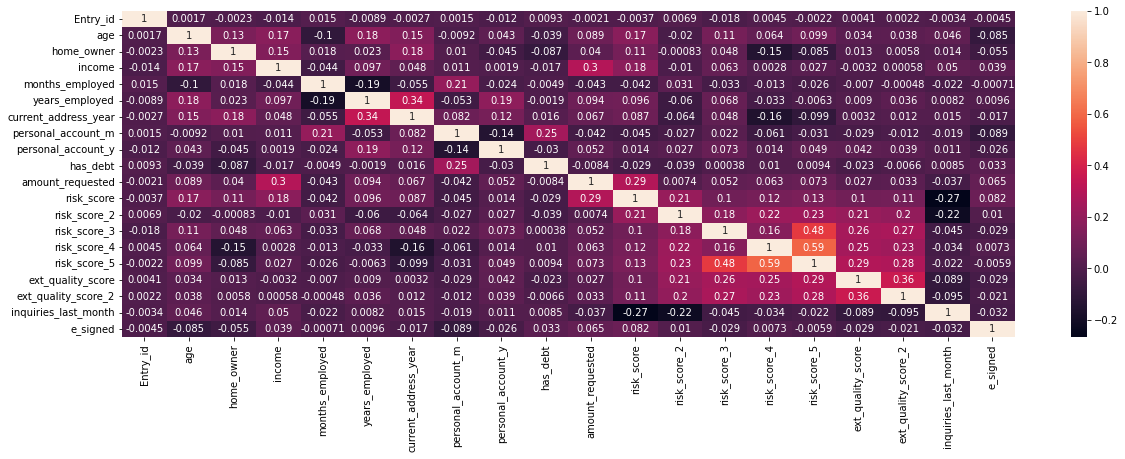

In [5]:
plt.figure(figsize=(20, 6))
sns.heatmap(df_train.corr(), annot=True)

In [7]:
def correlation(dataset,threshold):
    col_corr=set() # set will contains unique values.
    corr_matrix=dataset.corr() #finding the correlation between columns.
    for i in range(len(corr_matrix.columns)): #number of columns
        for j in range(i):
            if abs(corr_matrix.iloc[i,j])>threshold: #checking the correlation between columns.
                colName=corr_matrix.columns[i] #getting the column name
                col_corr.add(colName) #adding the correlated column name heigher than threshold value.
    return col_corr #returning set of column names|

In [8]:
%%time
col=correlation(df_train.drop(columns=['Entry_id','e_signed']),0.99)
print('Correlated columns:',col)
print(len(col))

Correlated columns: set()
0
CPU times: user 25.2 ms, sys: 1.01 ms, total: 26.2 ms
Wall time: 26.7 ms


The result shows that are no correlated columns, great!!!

Data Preprocessing

It should be noted that the pay_schedule column is not numeric. We will encode it become building our model as follows:  

In [9]:
pay_schedule_dict = {'bi-weekly': 1/24, 'weekly': 1/48, 'semi-monthly': 1/16, 'monthly': 1/12 }

In [10]:
df_train['pay_schedule'] = df_train['pay_schedule'].map(pay_schedule_dict)
df_test['pay_schedule'] = df_test['pay_schedule'].map(pay_schedule_dict)

Now, seeing that the 'amount_requested' would be a significant feature that would influence our model, we will engineer another column named 'total_income' from it 

In [12]:
df_train['total_income'] = df_train['income']+df_train['amount_requested']
df_test['total_income'] = df_test['income']+df_test['amount_requested']

The total_income column represents the total monetary value of each cusomer after recieving the loan

We will engineer another column called 'yearly_income' as follows:

In [13]:
df_train['yearly_income'] = df_train['income'] * df_train['years_employed']
df_test['yearly_income'] = df_test['income'] * df_test['years_employed']

Next, we will split the train dataset into features and taget. We will also drop the 'Entry_id' column as it's effect on the model will be insignificant

In [14]:
df_train_features = df_train.drop(['Entry_id','e_signed'], axis = 1)
y = df_train_target = df_train['e_signed']
test = df_test.drop(['Entry_id'], axis=1)

In [15]:
df_train_features.shape, df_train_target.shape, test .shape

((12516, 21), (12516,), (5392, 21))

### Feature Scaling

Now, we will scale both the train and test dataset features using a MinMaxScaler

In [16]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
X = scaler.fit_transform(df_train_features)
Z = scaler.fit_transform(test)

In [17]:
X = pd.DataFrame(X, columns =df_train_features.columns)
X.head()

,age,pay_schedule,home_owner,income,months_employed,years_employed,current_address_year,personal_account_m,personal_account_y,has_debt,...,risk_score,risk_score_2,risk_score_3,risk_score_4,risk_score_5,ext_quality_score,ext_quality_score_2,inquiries_last_month,total_income,yearly_income
0,0.282051,0.333333,1.0,0.245595,0.0,0.1875,0.250000,0.545455,0.142857,1.0,...,0.349206,0.731147,0.825625,0.489487,0.431680,0.594474,0.389757,0.310345,0.125035,0.084331
1,0.192308,0.666667,0.0,0.295705,0.0,0.3125,0.166667,0.181818,0.571429,1.0,...,0.529954,0.608251,0.741705,0.620201,0.609713,0.765000,0.768498,0.379310,0.181385,0.160950
2,0.038462,0.000000,0.0,0.153965,0.0,0.3125,0.666667,0.181818,0.500000,1.0,...,0.745008,0.669422,0.561305,0.497694,0.608806,0.606596,0.506007,0.172414,0.081189,0.103250
3,0.102564,0.333333,0.0,0.208150,0.0,0.2500,0.333333,0.090909,0.428571,1.0,...,0.498720,0.731819,0.770273,0.675231,0.651223,0.597820,0.705494,0.448276,0.119989,0.100247
4,0.320513,0.333333,0.0,0.450991,0.0,0.1250,0.083333,0.090909,0.142857,1.0,...,0.686124,0.793503,0.712831,0.400378,0.494550,0.537173,0.748995,0.137931,0.260443,0.089666


In [18]:
Z = pd.DataFrame(Z, columns =test.columns)
Z.head()

,age,pay_schedule,home_owner,income,months_employed,years_employed,current_address_year,personal_account_m,personal_account_y,has_debt,...,risk_score,risk_score_2,risk_score_3,risk_score_4,risk_score_5,ext_quality_score,ext_quality_score_2,inquiries_last_month,total_income,yearly_income
0,0.632353,0.000000,0.0,0.244791,0.000000,0.400000,0.250000,0.181818,0.466667,1.0,...,0.270954,0.686391,0.744899,0.727481,0.782649,0.756158,0.631528,0.275862,0.168665,0.160620
1,0.073529,0.000000,0.0,0.058067,0.545455,0.000000,0.000000,0.636364,0.066667,1.0,...,0.317343,0.571813,0.497416,0.590752,0.700603,0.547311,0.518539,0.206897,0.025580,0.000000
2,0.323529,0.333333,0.0,0.478197,0.000000,0.400000,0.083333,0.181818,0.466667,1.0,...,0.397470,0.598480,0.917433,0.790305,0.721776,0.821047,0.587970,0.241379,0.340528,0.264164
3,0.205882,0.666667,0.0,0.481612,0.272727,0.000000,0.250000,0.090909,0.266667,1.0,...,0.628361,0.583132,0.574985,0.589363,0.442256,0.586924,0.333376,0.068966,0.378897,0.000000
4,0.632353,0.333333,1.0,0.255038,0.000000,0.266667,0.000000,0.363636,0.200000,1.0,...,0.603585,0.591897,0.866529,0.887876,0.730563,0.653046,0.747640,0.206897,0.159872,0.110110


In [19]:
X.shape, y.shape, Z.shape

((12516, 21), (12516,), (5392, 21))

### Modeling

In [24]:
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=1235)

def run(trial):

  for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, y)):
    X_trn, y_trn = X.iloc[trn_idx], y.iloc[trn_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1)
    max_depths = trial.suggest_int('max_depth', 5, 8)
    n_estimators = trial.suggest_int('n_estimators', 100, 3000)
    min_child_samples = trial.suggest_int('min_child_samples', 5, 25)
    l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 0.0,10.0)
    colsample_bylevel = trial.suggest_float('colsample_bylevel', 0.1,1.0)
        
    clf = CatBoostClassifier(random_state=15,learning_rate=learning_rate, eval_metric='AUC', depth=max_depths,n_estimators=n_estimators,  
                  l2_leaf_reg=l2_leaf_reg, min_child_samples=min_child_samples,
                  colsample_bylevel=colsample_bylevel,  silent=True)
    
    clf.fit(X_trn, y_trn, eval_set = [(X_val, y_val)],verbose=0, early_stopping_rounds=100)
    
    vp = clf.predict_proba(X_val)[:,1]
    val_score = roc_auc_score((y_val), (vp))

    return val_score

### Performance Tuning

In [21]:
%%time
study = optuna.create_study(study_name="lgb_optimization",
                            direction="minimize",
                            sampler=TPESampler())
study.optimize(run, n_trials=30)

[I 2022-10-06 09:21:44,820] A new study created in memory with name: lgb_optimization
[I 2022-10-06 09:21:46,236] Trial 0 finished with value: 0.6874651595915483 and parameters: {'learning_rate': 0.07806793429820322, 'max_depth': 6, 'n_estimators': 268, 'min_child_samples': 7, 'l2_leaf_reg': 3.5416308192363033, 'colsample_bylevel': 0.154053753898538}. Best is trial 0 with value: 0.6874651595915483.
[I 2022-10-06 09:21:48,403] Trial 1 finished with value: 0.6767272493738361 and parameters: {'learning_rate': 0.01637407337325995, 'max_depth': 5, 'n_estimators': 414, 'min_child_samples': 7, 'l2_leaf_reg': 8.622761509759325, 'colsample_bylevel': 0.6738028238294813}. Best is trial 1 with value: 0.6767272493738361.
[I 2022-10-06 09:21:50,813] Trial 2 finished with value: 0.688187014321495 and parameters: {'learning_rate': 0.04355039205575948, 'max_depth': 5, 'n_estimators': 2581, 'min_child_samples': 15, 'l2_leaf_reg': 9.56992239972595, 'colsample_bylevel': 0.5543988469117278}. Best is trial 

CPU times: user 3min 56s, sys: 57.9 s, total: 4min 54s
Wall time: 1min 24s


In [26]:
study.best_params

{'learning_rate': 0.05905691073707391,
 'max_depth': 8,
 'n_estimators': 1177,
 'min_child_samples': 11,
 'l2_leaf_reg': 0.0212071811733745,
 'colsample_bylevel': 0.2328265089038854}

In [27]:
cat_params2 = {'learning_rate': 0.05905691073707391,
 'max_depth': 8,
 'n_estimators': 1177,
 'min_child_samples': 11,
 'l2_leaf_reg': 0.0212071811733745,
 'colsample_bylevel': 0.2328265089038854}

Now, we will train our model with the best hyperparameters and make prediction on the test data

In [28]:
%%time
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=1235)
oofs = np.zeros((len(X)))
preds = np.zeros((len(test)))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, y)):
    
    X_trn, y_trn = X.iloc[trn_idx], y.iloc[trn_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
    
    
    clf = CatBoostClassifier(**cat_params2, eval_metric='AUC')
    clf.fit(X_trn, y_trn, eval_set = [(X_val, y_val)],verbose=400, early_stopping_rounds=100)
    
    vp = clf.predict_proba(X_val)[:,1]
    b = pd.DataFrame(vp)
    b[0] = np.where(b[0]>0.45, 1, 0)
    val_score = roc_auc_score((y_val), (vp))
    
    print(f'\nFold {fold_+1} Val score: {val_score}\n')
    
    print(recall_score((y_val), (b[0])))
    
    print(precision_score((y_val), (b[0])))
    
    print(confusion_matrix((y_val), (b[0])))
    
    tp = clf.predict_proba(test)[:,1]
    
    oofs[val_idx] = vp
    preds += tp/10

a = pd.DataFrame(oofs)
a[0] = np.where(a[0]>0.25, 1, 0)
oof_score = roc_auc_score((y), (oofs))
print(f'\nOOF AUC score is : {oof_score}')

0:	test: 0.5818599	best: 0.5818599 (0)	total: 10.2ms	remaining: 12s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6744537923
bestIteration = 287

Shrink model to first 288 iterations.

Fold 1 Val score: 0.6744537923062103

0.7902511078286558
0.6128293241695304
[[237 338]
 [142 535]]
0:	test: 0.5984946	best: 0.5984946 (0)	total: 9.07ms	remaining: 10.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6775236016
bestIteration = 106

Shrink model to first 107 iterations.

Fold 2 Val score: 0.6775236015670156

0.8463810930576071
0.6115261472785486
[[211 364]
 [104 573]]
0:	test: 0.5769032	best: 0.5769032 (0)	total: 9.09ms	remaining: 10.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6580592126
bestIteration = 37

Shrink model to first 38 iterations.

Fold 3 Val score: 0.65805921263888

0.912850812407681
0.575955265610438
[[120 455]
 [ 59 618]]
0:	test: 0.6206705	best: 0.6206705 (0)	total: 8.92ms	remaining: 10.5s
Stopped by 

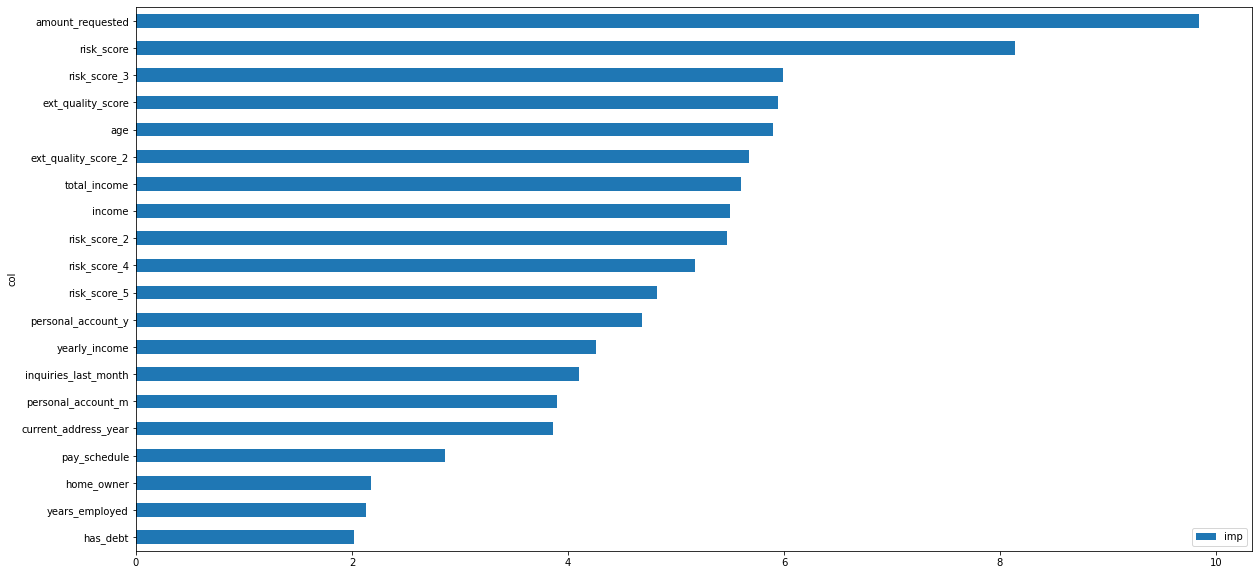

In [29]:
fea_imp = pd.DataFrame({'imp':clf.feature_importances_, 'col': X.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-20:]
_ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))

From the result, it is evident that our assumption is right, 'amount_requested' has the most effect on the model

### Saving the result

In [21]:
final = {'Entry_id':df_test['Entry_id'], 'e_signed':preds}

final_sub = pd.DataFrame(final)
final_sub.head()

,Entry_id,e_signed
0,3560428,0.472098
1,6934997,0.571992
2,5682812,0.482841
3,6493191,0.556793
4,8990111,0.533970


In [24]:
# We will save the result in a csv file called DTS_TEAM_Hackathon
final_sub.to_csv('DTS_TEAM_Hackathon.csv', index=False)